In [28]:
%pylab inline
from math import sqrt, exp, pow
import random

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Uniform random sampling
--
*Hint: this will not be optimal*

Samplers return a pair (x, p(x)), where x is random value and p(x) is its probability density.

In [29]:
def uniform_sampler():
    return random.random(), 1

Monte Carlo integration
--
This function returns a pair of arrays, where the first array has a list of successively more accurate estimates of the integral value (on [0, 1]), and the second one has the iteration indices for plotting.

In [30]:
def integrate_mc(function, sampler, N):
    estimates = [0] * N
    sum = 0
    for i in range(N):
        x, pdf = sampler()
        sum += function(x) / pdf
        estimates[i] = sum / (i+1)
    return estimates, np.arange(1, N+1)

A simple test
--
We're going to test on a simpler function, for which we know the value of the integral: f(x) = x. The expected integral value is 0.5.

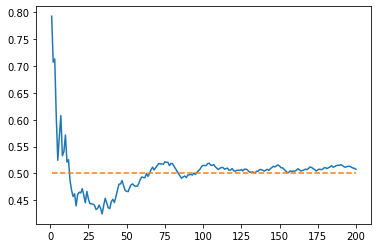

In [31]:
random.seed(8890)
estimates_x, indices_x = integrate_mc(lambda x: x, uniform_sampler, 200)
plt.plot(indices_x, estimates_x)
plt.plot([indices_x[0], indices_x[-1]], [0.5, 0.5], ls='--')

Some words on convergence
--
In Monte Carlo integration, we expect the error to be proportional to 1/sqrt(N). Let's look at that error.

In [63]:
def plot_mc_error(indices, all_estimates, expected_value, axes=None):
    rmse = [0] * len(indices)
    for estimates in all_estimates:
        for i, e in enumerate(estimates):
            err = e-expected_value
            rmse[i] += err*err
    rmse = [sqrt(e/len(all_estimates)) for e in rmse]
    expected = [rmse[0]/sqrt(n) for n in indices]
        
    if axes is None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    axes[0].plot(indices, rmse)
    axes[0].plot(indices, expected, color='black', ls='--')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].plot(indices, rmse)
    axes[1].plot(indices, expected, color='black', ls='--')
    return axes


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

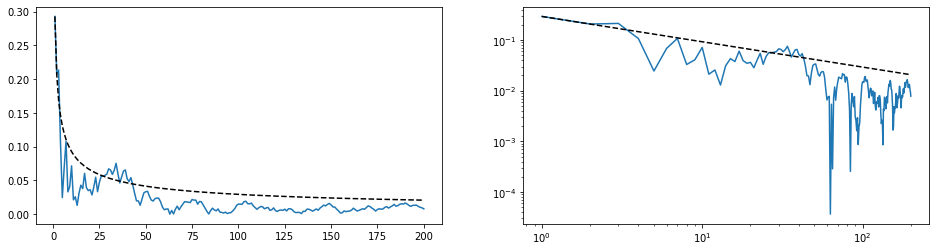

In [65]:
plot_mc_error(indices_x, [estimates_x], 0.5)

Note how in the log-log plot, the expected error is a line - this is because the function has the form N^k (N^-1/2), and
log(pow(x, k)) = k * log(x). Also note that the error itself is a noisy estimate. We can improve the curve by averaging over many runs.

In [70]:
def plot_mc_rmse(function, sampler, num_runs, axes=None):
    all_estimates = []
    N = []
    for i in range(num_runs):
        estimates, N = integrate_mc(function, sampler, 100)
        all_estimates.append(estimates)
    expected = integrate_mc(function, sampler, 100000)[0][-1]
    return plot_mc_error(N, all_estimates, expected, axes)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

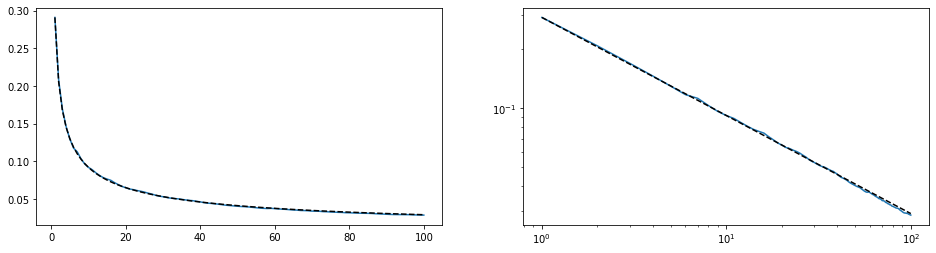

In [71]:
plot_mc_rmse(lambda x: x, uniform_sampler, 1000)

Importance Sampling
==

Now let's try the same thing on a more complicated function, exp(x*x). This function does not have an antiderivative,
and so we cannot integrate it analytically.

In [72]:
def exx(x):
    return exp(x*x)

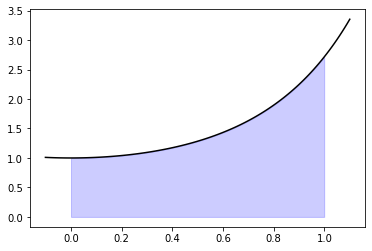

In [73]:
x = np.linspace(-0.1, 1.1, 120)
y = [exx(x) for x in x]
xh = [x for x in x if x >= 0 and x <= 1]
yh = [exx(x) for x in xh]
plt.fill_between(xh, yh, color=(0, 0, 1, 0.2))
plt.plot(x, y, color='black')

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

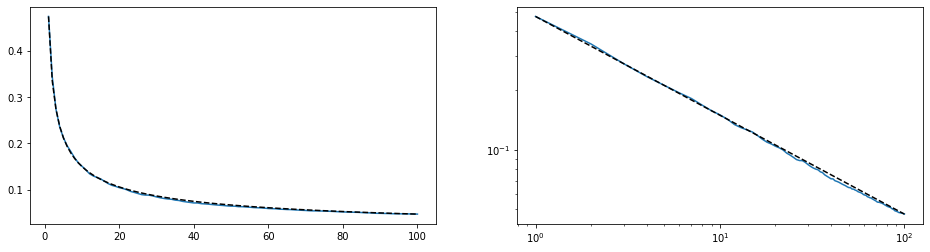

In [74]:
plot_mc_rmse(exx, uniform_sampler, 1000)

Note how the function has larger values near 1. In other words, more of the area under the curve is near 1 than near 0, which means that the right half is more important for the integral.

We can choose the probability density function p(x) freely, and choosing it roughly proportional to the function we integrate will reduce noise considerably, because we will place more samples where they are important. This is called *importance sampling*.

We'll choose the function p(x) proportional to 1+x, because 1+x is somewhat similar in shape to exp(x*x) (smaller values on the left, larger values on the right). Due to the normalization required for a pdf, it turns out that
p(x) = 2/3 (1+x). We obtain the sampler by using the inverse CDF method.

In [75]:
def xpo_sampler():
    x = sqrt(1+3*random.random())-1
    pdf = 2/3 * (1+x)
    return x, pdf

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

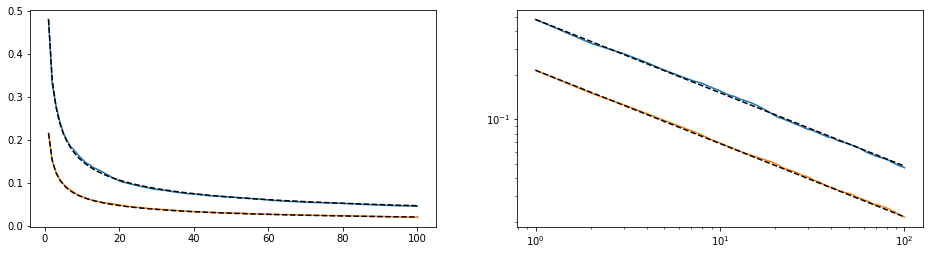

In [76]:
ax=plot_mc_rmse(exx, uniform_sampler, 1000)
plot_mc_rmse(exx, xpo_sampler, 1000, ax)

As you can see, the error is only about half as large at any time (an RMSE of 0.1 is obtained after about 5 iterations (orange line), where uniform sampling needed around 20 (blue line)).